# Anonimização de imagem
## Curso de Fotografia Computacional

### Upload de imagens

In [ ]:
from google.colab.files import upload
_ = upload()

Saving faces.jpg to faces.jpg


### Imports

In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 45.1 MB/s eta 0:00:00


In [ ]:
import cv2
import mediapipe as mp
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
def show_image(img, figsize=(30, 15)):
  fig = plt.figure(figsize=figsize)
  ax = fig.add_subplot(1, 1, 1)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(img, cmap="gray")
  plt.show()

def show_images(img_list, figsize=None):
  n = len(img_list)
  if figsize == None:
    figsize = (5 * n, 8)
  fig, ax = plt.subplots(1, n, figsize=figsize)
  for i in range(n):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].imshow(img_list[i], cmap="gray")
  plt.show()

### Carregando imagens

In [ ]:
files = glob("*.jpeg") + glob("*.jpg") + glob("*.png") + glob("*.tiff")
files

['faces.jpg']

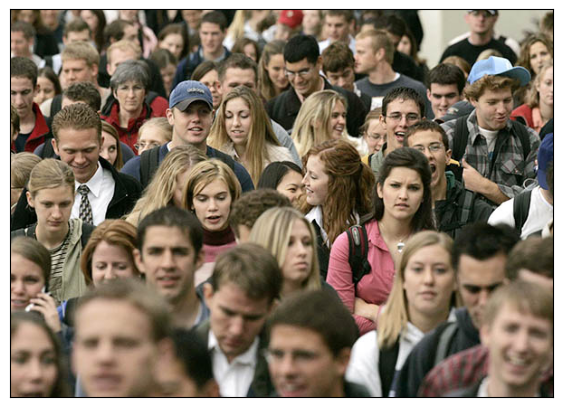

In [ ]:
image = cv2.imread(files[0])[..., ::-1]
show_image(image, (7, 7))

### Executando a anonimização de imagem

Configuração dos detectores de face

In [ ]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt.xml
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt2.xml
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

--2023-12-06 15:39:59--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 676709 (661K) [text/plain]
Saving to: ‘haarcascade_frontalface_alt.xml’

haarcascade_frontal 100%[===================>] 660.85K  --.-KB/s    in 0.05s   

2023-12-06 15:40:00 (12.6 MB/s) - ‘haarcascade_frontalface_alt.xml’ saved [676709/676709]

--2023-12-06 15:40:00--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt2.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... 

In [ ]:
face_cascade = cv2.CascadeClassifier()
face_cascade.load("haarcascade_frontalface_alt.xml")

True

Pré-processamento da imagem

In [ ]:
# Os detectores esperam imagens em escala de cinza
image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

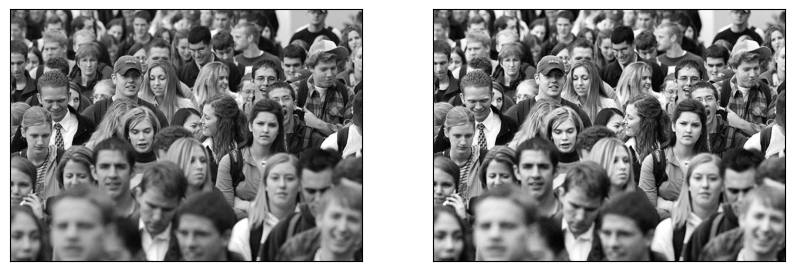

In [ ]:
# equalização local do histograma
clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(5, 5))
image_clahe = clahe.apply(image_gray)
show_images([image_gray, image_clahe])

Pixelização dos rostos através de downsampling agressivo com interpolação nearest neighbours

In [ ]:
result = image.copy()
faces = face_cascade.detectMultiScale(image_clahe)
for (x, y, w, h) in faces:
    patch_rsz = cv2.resize(result[y:y+h, x:x+w], None, fx=0.075, fy=0.075)
    result[y:y+h, x:x+w] = cv2.resize(patch_rsz, (h, w),
                                     interpolation=cv2.INTER_NEAREST)

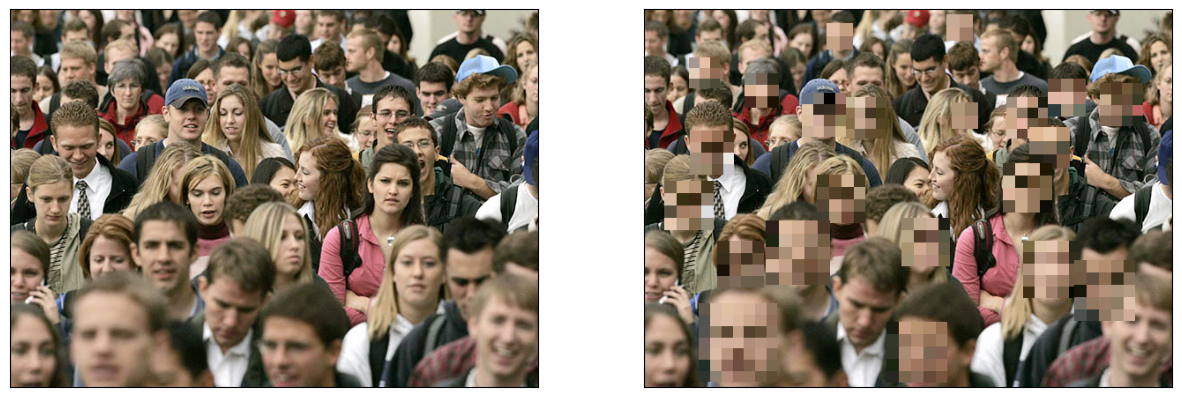

In [ ]:
show_images([image, result], (15, 15))

In [ ]:
face_detector = mp.solutions.face_detection.FaceDetection(
    model_selection=1, min_detection_confidence=0.5
)

In [ ]:
output = face_detector.process(image)

In [ ]:
result2 = image.copy()
assert (len(output.detections) > 0), "No faces detected"
for id, detection in enumerate(output.detections):
    box_rel = detection.location_data.relative_bounding_box
    image_h, image_w, _ = image.shape
    x, y, w, h = (
        int(box_rel.xmin * image_w),
        int(box_rel.ymin * image_h),
        int(box_rel.width * image_w),
        int(box_rel.height * image_h)
    )

    result2[y:y+h, x:x+w] = 0

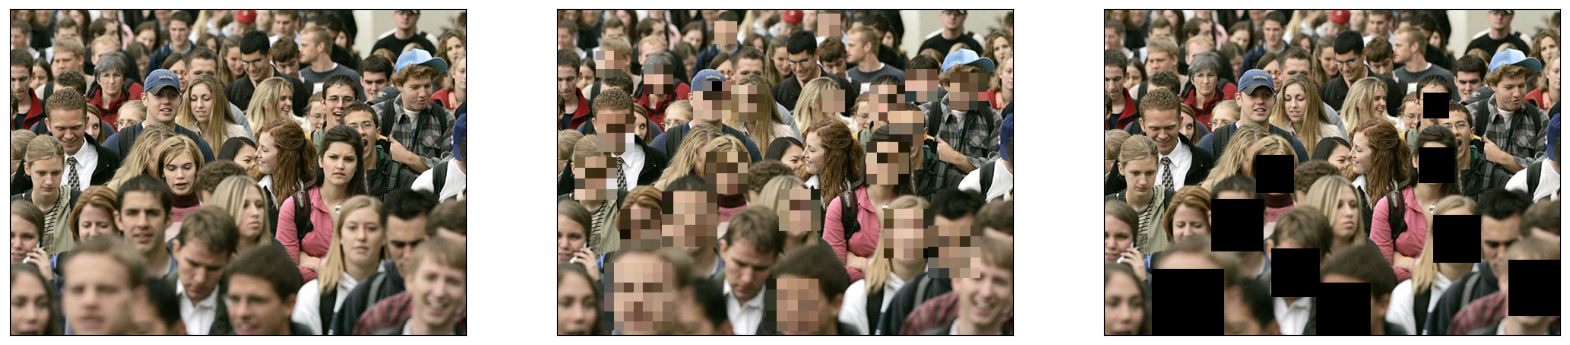

In [ ]:
show_images([image, result, result2], (20, 20))